In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import dv_processing as dv
import numpy as np
import helper_funcs as hf

## Helper Functions


In [2]:

def plot_batches(batches, subject, letter):
    """
    Plot the number of events per batch.

    Args:
    batches (pd.DataFrame): The DataFrame containing batch information.
    subject (int): The subject number.
    letter (str): The letter.
    """
    plt.clf()
    plt.bar(batches['batch'], batches['num_events'], color="tab:blue")
    plt.title(f"# of Events per Batch - Subject {subject} Letter {letter}")
    plt.xlabel("Batch")
    plt.ylabel("# of Events")
    
def plot_sample_freq(sample_freq, batchN):
    """
    Plot the number of events in each sample.

    Args:
    sample_freq (np.ndarray): Array containing the number of events in each sample.
    batchN (int): The batch number.
    """

    peak_events = np.max(sample_freq)
    max_idx = np.where(sample_freq == peak_events)[0]
    print(f"Maximum # of events in batch: {peak_events} @ Sample {max_idx}")

    plt.clf()
    x = np.arange(len(sample_freq))
    plt.plot(x, sample_freq, marker='.', color="tab:blue")
    plt.scatter(max_idx, peak_events, marker="o", color='tab:red', zorder=3)
    plt.xlabel("Sample")
    plt.ylabel("# of Events")
    plt.title(f"# of Events in Each Sample - Batch {batchN}")

def cut_events(sample_freqN, threshold=1000):
    cut = np.where(sample_freqN > threshold)[0]
    cut_points = np.array([sample_freqN[i] for i in cut])
    return cut_points

### Data settings

In [3]:
# General settings
subject = 1
letter = 'f'
AEDAT = f"../data/aedat/subject{subject}/{letter}.aedat4"
CSV = f"../data/csv/subject{subject}/{letter}_events.csv"
DEBUG = True  # Debug mode - print statements

# Set time to split recording
batch_time = int(3e6) # 3e6 microseconds = 3 seconds worth of events

### Recording Metadata

This cell reads in the entire recording for the `subject` and `letter` specified. Then, it will split the reocrding into batches according the the specified `batch_time` (in microseconds). It will then store the batch metadata into a DataFrame for ease of use later.

In [4]:
recording = dv.io.MonoCameraRecording(AEDAT) # Read in whole entire recording
metadata = hf.split_recording(recording, batch_time, DEBUG) # Track metadata - (resolution, batch_size, num_batches, t0, t1)
batches = hf.get_batches(recording, metadata) # Creates batches from recording
df = pd.read_csv(CSV) # Read entire CSV from converted AEDAT4.0 file

batches.iloc[:5] # Print first 5 rows of DataFrame

Event resolution: (240, 180)
Recording duration: 81.728724 secs
Start timestamp: 124288256
End timestamp: 206016980


,batch,t0,t1,duration,num_events
0,0,124288256,127288256,2999999,275695
0,1,127288256,130288256,2999848,360538
0,2,130288256,133288256,2999945,323390
0,3,133288256,136288256,2999980,315518
0,4,136288256,139288256,2999948,317157


### Visualize Events Per Batch

For each batch (as seen above), you can see how the number of events varies at different points in the recording. This seems to correlate to the event distribution per sample that we see in the next section.

In [ ]:
plt.bar(batches['batch'], batches['num_events'], color="tab:blue")
plt.title(f"Number of Events per Batch - Subject {subject} Letter {letter}")
plt.xlabel("Batch")
plt.ylabel("Number of Events")

### Visualize  Events Per Sample in Batch

For a single batch, we can observe that the number of events peaks when the subject's hand is in peak motion. Peak motion correlates to maximum kinetic energy in the hand's oscillation back and forth within the frame. Between motion inflection points (left, right), we see that there are approximately 0 events captured by the camera. This makes sense as the DVS camera will only pick up changes in pixels, so if there is no motion, then there are no events occurring.

In [ ]:
batchN = 0 # Toggle this to get another batch recording
batch = hf.get_batch_indices(df, batches, batchN, DEBUG)
sample_freqN, _ = hf.get_sample_freq_from_batch(batch, metadata)

plot_sample_freq(sample_freqN, batchN)

In [ ]:
batchN = 13 
batch = hf.get_batch_indices(df, batches, batchN, DEBUG)
sample_freqN, _ = hf.get_sample_freq_from_batch(batch, metadata)
plot_sample_freq(sample_freqN, batchN)

In [ ]:
batchN = 20 
batch = hf.get_batch_indices(df, batches, batchN, DEBUG)
sample_freqN, _ = hf.get_sample_freq_from_batch(batch, metadata)
plot_sample_freq(sample_freqN, batchN)

In [ ]:
batchN = 21
batch = hf.get_batch_indices(df, batches, batchN, DEBUG)
sample_freqN, _ = hf.get_sample_freq_from_batch(batch, metadata)
plot_sample_freq(sample_freqN, batchN)

## Random Sampling

1. Create random samples of 3 sec each, containing 100 microseconds bins. 

In [30]:
batchN = np.arange(0, len(batches))
np.random.shuffle(batchN)
batchN = batchN[:3]

subset = pd.DataFrame()
sample_freqs = []


for b in sorted(batchN):
    batch = hf.get_batch_indices(df, batches, b, DEBUG)
    sample_freqN, _ = hf.get_sample_freq_from_batch(batch, metadata)
    sample_freqN = cut_events(sample_freqN)

    subset = pd.concat([subset, batch])
    sample_freqs.append(sample_freqN)


Number of events in Batch 6: 279386
Number of events in Batch 7: 313677
Number of events in Batch 11: 275344


Text(0, 0.5, '# of Events')

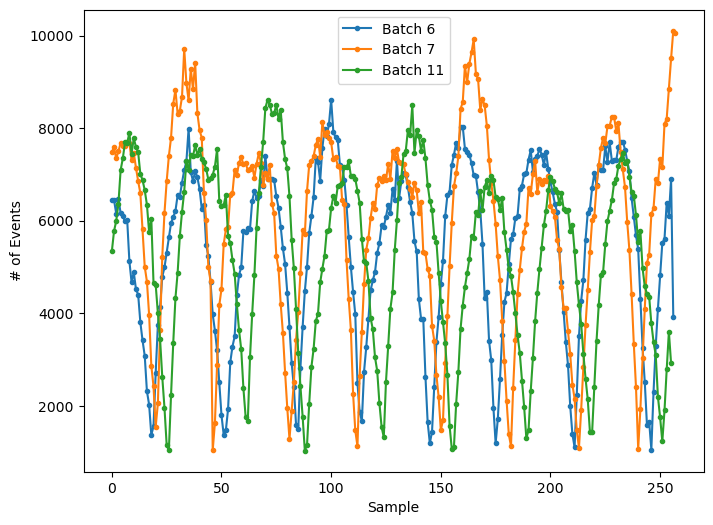

In [31]:
plt.figure(figsize=(8, 6))
for i, b in enumerate(batchN):
    plt.plot(np.arange(0, len(sample_freqs[i])), sample_freqs[i], marker='.', label=f"Batch {b}")

plt.legend()
plt.xlabel("Sample")
plt.ylabel("# of Events")